# Project B-Task 2: Knowledge Distillation for Building Lightweight Deep Learning Models in Visual Classification Tasks

## Load the pre-trained models

In [9]:
# from google.colab import drive
# drive.mount('/content/drive')

In [10]:
# # Remove all
# !rm -rf __MACOSX/
# !rm -rf images.zip
# !rm -rf images/
# !rm -rf sample_data/

In [11]:
# # Debugging
# !pwd
# !ls
# # Run only once (if execute environment expired.)
# !wget https://github.com/Awesome-guys-in-ECE1747/ECE1512_2022W_ProjectRepo_J.Xu_and_W.Xu/releases/download/1.0.b/annotations.csv
# !wget https://github.com/Awesome-guys-in-ECE1747/ECE1512_2022W_ProjectRepo_J.Xu_and_W.Xu/releases/download/1.0.b/images.zip

# !unzip -q images.zip

## Import Dependencies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.compat.v2 as tf
import tensorflow_datasets as tensorflow_datasets
from typing import Union
tf.enable_v2_behavior()

print(len(tf.config.experimental.list_physical_devices('GPU')))
########Only Step3-Step8, Step13 have to be implemented with MHIST###########

0


In [13]:
BATCH_SIZE = 32
INIT_EPOCH_NUM = 10
FINE_EPOCH_NUM = 25

ENTROPY_ZERO_FILTER = 1e-15

NUM_CLASSES = 2 # Binary: SSA/HP

TRAIN_BATCH_NUM = int(np.floor(2176/BATCH_SIZE))
TEST_BATCH_NUM = int(np.floor(976/BATCH_SIZE))

## Data Preprocessing

In [14]:
pd.options.display.max_rows = 500
pd.set_option('display.notebook_repr_html', True)

def _repr_latex_(self):
    return "\centering{%s}" % self.to_latex()

pd.DataFrame._repr_latex_ = _repr_latex_

In [15]:
import os
import sys
annotation_path = 'annotations.csv'

In [16]:
raw_data = pd.read_csv(annotation_path)
# raw_data.shape
raw_data.any()

Image Name                                          True
Majority Vote Label                                 True
Number of Annotators who Selected SSA (Out of 7)    True
Partition                                           True
dtype: bool

In [17]:
train_data = raw_data.query("Partition == 'train'")
test_data = raw_data.query("Partition == 'test'")
print("Train Data Size", train_data.shape)
print("Test Data Size", test_data.shape)

Train Data Size (2175, 4)
Test Data Size (977, 4)


In [18]:
print(train_data[0:5].transpose())

                                                              0  \
Image Name                                        MHIST_aaa.png   
Majority Vote Label                                         SSA   
Number of Annotators who Selected SSA (Out of 7)              6   
Partition                                                 train   

                                                              1  \
Image Name                                        MHIST_aab.png   
Majority Vote Label                                          HP   
Number of Annotators who Selected SSA (Out of 7)              0   
Partition                                                 train   

                                                              2  \
Image Name                                        MHIST_aac.png   
Majority Vote Label                                         SSA   
Number of Annotators who Selected SSA (Out of 7)              5   
Partition                                                 tr

(224, 224, 3)


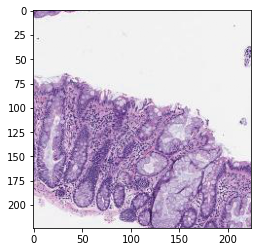

In [19]:
import matplotlib.image as mp

sample_image = mp.imread("./images/MHIST_aac.png")
print(sample_image.shape)
plt.imshow(sample_image)

In [20]:
print(test_data[0:5].transpose())

                                                             5   \
Image Name                                        MHIST_aag.png   
Majority Vote Label                                          HP   
Number of Annotators who Selected SSA (Out of 7)              2   
Partition                                                  test   

                                                             6   \
Image Name                                        MHIST_aah.png   
Majority Vote Label                                          HP   
Number of Annotators who Selected SSA (Out of 7)              2   
Partition                                                  test   

                                                             14  \
Image Name                                        MHIST_aaq.png   
Majority Vote Label                                         SSA   
Number of Annotators who Selected SSA (Out of 7)              5   
Partition                                                  t

(224, 224, 3)


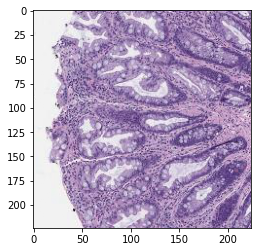

In [21]:
sample_image = mp.imread("./images/MHIST_aar.png")
print(sample_image.shape)
plt.imshow(sample_image)

In [22]:
from keras.preprocessing.image import ImageDataGenerator
train_set_generator = ImageDataGenerator(rescale=1/255., shear_range=0.1, rotation_range=15, horizontal_flip=True, vertical_flip=True)
test_set_generator = ImageDataGenerator(rescale=1/255.)

In [23]:
train_generator = train_set_generator.flow_from_dataframe(
    dataframe=train_data,
    x_col='Image Name',
    y_col='Majority Vote Label',
    directory='./images/',
    # subset='training',
    batch_size=32,
    shuffle=True,
    class_mode="categorical",
    target_size=(224,224)
)
train_alt_generator = train_set_generator.flow_from_dataframe(
    dataframe=train_data,
    x_col='Image Name',
    y_col='Majority Vote Label',
    directory='./images/',
    # subset='training',
    batch_size=32,
    shuffle=True,
    class_mode="categorical",
    target_size=(224,224)
)

Found 2175 validated image filenames belonging to 2 classes.
Found 2175 validated image filenames belonging to 2 classes.


In [24]:
test_generator = test_set_generator.flow_from_dataframe(
    dataframe=test_data,
    x_col='Image Name',
    y_col='Majority Vote Label',
    directory='./images/',
    # subset='validation',
    batch_size=32,
    shuffle=True,
    class_mode="categorical",
    target_size=(224,224)
)
# Please Notice Batch Size 32?/2?

Found 977 validated image filenames belonging to 2 classes.


## Model Creation

In [25]:
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.layers import Dense
from tensorflow.keras import Sequential

In [26]:
teacher_model = Sequential()
teacher_model.add(ResNet50V2(classifier_activation = None, input_shape = (224,224,3)))
teacher_model.add(Dense(NUM_CLASSES))
print(teacher_model.summary())

102883328/102869336 [==============================] - 5s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 1000)              25613800  
                                                                 
 dense (Dense)               (None, 2)                 2002      
                                                                 
Total params: 25,615,802
Trainable params: 25,570,362
Non-trainable params: 45,440
_________________________________________________________________
None


In [27]:
student_model = Sequential()
student_model.add(MobileNetV2(classifier_activation=None, input_shape=(224,224,3)))
student_model.add(Dense(NUM_CLASSES))
print(student_model.summary())

14548992/14536120 [==============================] - 1s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 1000)             3538984   
 ional)                                                          
                                                                 
 dense_1 (Dense)             (None, 2)                 2002      
                                                                 
Total params: 3,540,986
Trainable params: 3,506,874
Non-trainable params: 34,112
_________________________________________________________________
None


In [28]:
student_model_nokd = Sequential()
student_model_nokd.add(MobileNetV2(classifier_activation=None, input_shape=(224,224,3)))
student_model_nokd.add(Dense(NUM_CLASSES))
print(student_model_nokd.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 1000)             3538984   
 ional)                                                          
                                                                 
 dense_2 (Dense)             (None, 2)                 2002      
                                                                 
Total params: 3,540,986
Trainable params: 3,506,874
Non-trainable params: 34,112
_________________________________________________________________
None


## Teacher Loss Function

In [29]:
def compute_teacher_loss(model, images, labels, **kwargs):
    """Compute class knowledge distillation teacher loss for given images
     and labels.

    Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.
    kwargs: n/a

    Returns:
    Scalar loss Tensor.
    """
    
    class_logits = model(images, training=True)
    cross_entropy_loss_value = tf.nn.softmax_cross_entropy_with_logits(labels, class_logits)
    return cross_entropy_loss_value

## Student KD Loss


In [30]:
# adapted from https://keras.io/examples/vision/knowledge_distillation/

def distillation_loss(teacher_logits: tf.Tensor, student_logits: tf.Tensor,
                      temperature: Union[float, tf.Tensor]):
    """Compute distillation loss.

    This function computes cross entropy between softened logits and softened
    targets. The resulting loss is scaled by the squared temperature so that
    the gradient magnitude remains approximately constant as the temperature is
    changed. For reference, see Hinton et al., 2014, "Distilling the knowledge in
    a neural network."

    Args:
    teacher_logits: A Tensor of logits provided by the teacher.
    student_logits: A Tensor of logits provided by the student, of the same
      shape as `teacher_logits`.
    temperature: Temperature to use for distillation.

    Returns:
    A scalar Tensor containing the distillation loss.
    """
    soft_targets = teacher_logits / temperature

    return tf.reduce_mean(
      tf.nn.softmax_cross_entropy_with_logits(
          soft_targets, student_logits / temperature)) * temperature ** 2

def compute_student_loss(student_model, images, labels, **kwargs):
    """Compute class knowledge distillation student loss for given images
     and labels.

    Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.
    kwargs:
        teacher_model: Teacher model
        temperature: Temperature hyperparameter
        alpha: Alpha hyperparameter

    Returns:
    Scalar loss Tensor.
    """
    
    teacher_model = kwargs['teacher_model']
    temperature = kwargs['temperature']
    alpha = kwargs['alpha']
    
    student_class_logits = student_model(images, training=True)

    # Compute class distillation loss between student class logits and
    # softened teacher class targets probabilities.

    teacher_class_logits = teacher_model(images, training=False)
    distillation_loss_value = distillation_loss(teacher_class_logits, student_class_logits, temperature)

    # Compute cross-entropy loss with hard targets.
    
    cross_entropy_loss_value = tf.nn.softmax_cross_entropy_with_logits(labels, student_class_logits)

    total_loss = alpha * cross_entropy_loss_value + (1 - alpha) * distillation_loss_value

    return total_loss

## Student Loss Function

In [31]:
def compute_student_scratch_loss(model, images, labels, **kwargs):
    """Compute class student (scratch) loss for given images
     and labels.

    Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.
    kwargs:
        temperature: Temperature hyperparameter

    Returns:
    Scalar loss Tensor.
    """
    temperature = kwargs['temperature']
    
    class_logits = model(images, training=True)

    # Compute cross-entropy loss for classes.
    
    cross_entropy_loss_value = tf.nn.softmax_cross_entropy_with_logits(labels, class_logits/temperature) * temperature ** 2

    return cross_entropy_loss_value

## Train and Evaluation

In [32]:
ALPHA = 0.5 # task balance between cross-entropy and distillation loss
DISTILLATION_TEMPERATURE = 4. # temperature hyperparameter

In [33]:
@tf.function
def compute_num_correct(model, images, labels):
  """Compute number of correctly classified images in a batch.

  Args:
    model: Instance of tf.keras.Model.
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Number of correctly classified images.
  """
  class_logits = model(images, training=False)
  return tf.reduce_sum(
      tf.cast(tf.math.equal(tf.argmax(class_logits, -1), tf.argmax(labels, -1)),
              tf.float32)), tf.argmax(class_logits, -1), tf.argmax(labels, -1)


def train_and_evaluate(model, compute_loss_fn, num_epochs, learning_rate, **kwargs):
    """Perform training and evaluation for a given model.

    Args:
    model: Main Instance of tf.keras.Model.
    compute_loss_fn: A function that computes the training loss given the
        images, and labels.
    num_epochs: Number of epochs to train for
    learning_rate: Optimizer learning rate
    kwargs: Passed through to loss fn
    """

    # your code start from here for step 4
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    train_generator.reset()
    
    accuracy = 0
    
    for epoch in range(1, num_epochs + 1):
        # Run training.
        print('Epoch {}: '.format(epoch), end='')

        #for images, labels in mhist_train:
        for batch in range(TRAIN_BATCH_NUM):
            
            images, labels = train_generator.next()

            with tf.GradientTape() as tape:

                loss_value = compute_loss_fn(model, images, labels, **kwargs)

            grads = tape.gradient(loss_value, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))

        # Run evaluation.
        num_correct = 0
        num_total = BATCH_SIZE*TEST_BATCH_NUM
        
        test_generator.reset()
        
        for batch in range(TEST_BATCH_NUM):
            images, labels = test_generator.next()
            num_correct += compute_num_correct(model,images,labels)[0]
        accuracy = num_correct / num_total * 100
        print("Class_accuracy: " + '{:.2f}%'.format(accuracy))
    
    return accuracy

## Excute Training

In [34]:
# Alpha = 0.5, Learning rate as table 1 in instruction

current_temperature = 1

print("========Teacher Model-Initial========")
teacher_init_acc = train_and_evaluate(teacher_model, compute_teacher_loss, INIT_EPOCH_NUM, 1e-4)
print("\n=========Teacher Model-Fine=========")
teacher_fine_acc = train_and_evaluate(teacher_model, compute_teacher_loss, FINE_EPOCH_NUM, 1e-5)

print("\n========Student(KD) Model-Initial========")
student_kd_init_acc = train_and_evaluate(student_model, compute_student_loss, INIT_EPOCH_NUM, 1e-3, teacher_model=teacher_model, temperature=current_temperature, alpha=0.5)
print("\n=========Student(KD) Model-Fine=========")
student_kd_fine_acc = train_and_evaluate(student_model, compute_student_loss, FINE_EPOCH_NUM, 1e-4, teacher_model=teacher_model, temperature=current_temperature, alpha=0.5)

print("\n========Student(Scratch)-Initial========")
student_nokd_init_acc = train_and_evaluate(student_model_nokd, compute_student_scratch_loss, INIT_EPOCH_NUM, 1e-3, temperature=current_temperature)
print("\n=========Student(Scratch)-Fine=========")
student_nokd_fine_acc = train_and_evaluate(student_model_nokd, compute_student_scratch_loss, FINE_EPOCH_NUM, 1e-4, temperature=current_temperature)

print("\n\n===============SUMMARY===============")
print("Current Temperature: ", current_temperature)
print("Teacher Initial Accuracy: ", teacher_init_acc)
print("Teacher Fine Accuracy: ", teacher_fine_acc)
print("Student(KD) Initial Accuracy: ", student_kd_init_acc)
print("Student(KD) Fine Accuracy: ", student_kd_fine_acc)
print("Student(Scratch) Initial Accuracy: ", student_nokd_init_acc)
print("Student(Scratch) Fine Accuracy: ", student_nokd_fine_acc)
print("=====================================")

========Teacher Model-Initial========
Epoch 1: 

KeyboardInterrupt: 

In [ ]:
# Alpha = 0.5, Learning rate as table 1 in instruction

current_temperature = 2

print("========Teacher Model-Initial========")
teacher_init_acc = train_and_evaluate(teacher_model, compute_teacher_loss, INIT_EPOCH_NUM, 1e-4)
print("\n=========Teacher Model-Fine=========")
teacher_fine_acc = train_and_evaluate(teacher_model, compute_teacher_loss, FINE_EPOCH_NUM, 1e-5)

print("\n========Student(KD) Model-Initial========")
student_kd_init_acc = train_and_evaluate(student_model, compute_student_loss, INIT_EPOCH_NUM, 1e-3, teacher_model=teacher_model, temperature=current_temperature, alpha=0.5)
print("\n=========Student(KD) Model-Fine=========")
student_kd_fine_acc = train_and_evaluate(student_model, compute_student_loss, FINE_EPOCH_NUM, 1e-4, teacher_model=teacher_model, temperature=current_temperature, alpha=0.5)

print("\n========Student(Scratch)-Initial========")
student_nokd_init_acc = train_and_evaluate(student_model_nokd, compute_student_scratch_loss, INIT_EPOCH_NUM, 1e-3, temperature=current_temperature)
print("\n=========Student(Scratch)-Fine=========")
student_nokd_fine_acc = train_and_evaluate(student_model_nokd, compute_student_scratch_loss, FINE_EPOCH_NUM, 1e-4, temperature=current_temperature)

print("\n\n===============SUMMARY===============")
print("Current Temperature: ", current_temperature)
print("Teacher Initial Accuracy: ", teacher_init_acc)
print("Teacher Fine Accuracy: ", teacher_fine_acc)
print("Student(KD) Initial Accuracy: ", student_kd_init_acc)
print("Student(KD) Fine Accuracy: ", student_kd_fine_acc)
print("Student(Scratch) Initial Accuracy: ", student_nokd_init_acc)
print("Student(Scratch) Fine Accuracy: ", student_nokd_fine_acc)
print("=====================================")

In [ ]:
# Alpha = 0.5, Learning rate as table 1 in instruction

current_temperature = 4

print("========Teacher Model-Initial========")
teacher_init_acc = train_and_evaluate(teacher_model, compute_teacher_loss, INIT_EPOCH_NUM, 1e-4)
print("\n=========Teacher Model-Fine=========")
teacher_fine_acc = train_and_evaluate(teacher_model, compute_teacher_loss, FINE_EPOCH_NUM, 1e-5)

print("\n========Student(KD) Model-Initial========")
student_kd_init_acc = train_and_evaluate(student_model, compute_student_loss, INIT_EPOCH_NUM, 1e-3, teacher_model=teacher_model, temperature=current_temperature, alpha=0.5)
print("\n=========Student(KD) Model-Fine=========")
student_kd_fine_acc = train_and_evaluate(student_model, compute_student_loss, FINE_EPOCH_NUM, 1e-4, teacher_model=teacher_model, temperature=current_temperature, alpha=0.5)

print("\n========Student(Scratch)-Initial========")
student_nokd_init_acc = train_and_evaluate(student_model_nokd, compute_student_scratch_loss, INIT_EPOCH_NUM, 1e-3, temperature=current_temperature)
print("\n=========Student(Scratch)-Fine=========")
student_nokd_fine_acc = train_and_evaluate(student_model_nokd, compute_student_scratch_loss, FINE_EPOCH_NUM, 1e-4, temperature=current_temperature)

print("\n\n===============SUMMARY===============")
print("Current Temperature: ", current_temperature)
print("Teacher Initial Accuracy: ", teacher_init_acc)
print("Teacher Fine Accuracy: ", teacher_fine_acc)
print("Student(KD) Initial Accuracy: ", student_kd_init_acc)
print("Student(KD) Fine Accuracy: ", student_kd_fine_acc)
print("Student(Scratch) Initial Accuracy: ", student_nokd_init_acc)
print("Student(Scratch) Fine Accuracy: ", student_nokd_fine_acc)
print("=====================================")

In [ ]:
# Alpha = 0.5, Learning rate as table 1 in instruction

current_temperature = 16

print("========Teacher Model-Initial========")
teacher_init_acc = train_and_evaluate(teacher_model, compute_teacher_loss, INIT_EPOCH_NUM, 1e-4)
print("\n=========Teacher Model-Fine=========")
teacher_fine_acc = train_and_evaluate(teacher_model, compute_teacher_loss, FINE_EPOCH_NUM, 1e-5)

print("\n========Student(KD) Model-Initial========")
student_kd_init_acc = train_and_evaluate(student_model, compute_student_loss, INIT_EPOCH_NUM, 1e-3, teacher_model=teacher_model, temperature=current_temperature, alpha=0.5)
print("\n=========Student(KD) Model-Fine=========")
student_kd_fine_acc = train_and_evaluate(student_model, compute_student_loss, FINE_EPOCH_NUM, 1e-4, teacher_model=teacher_model, temperature=current_temperature, alpha=0.5)

print("\n========Student(Scratch)-Initial========")
student_nokd_init_acc = train_and_evaluate(student_model_nokd, compute_student_scratch_loss, INIT_EPOCH_NUM, 1e-3, temperature=current_temperature)
print("\n=========Student(Scratch)-Fine=========")
student_nokd_fine_acc = train_and_evaluate(student_model_nokd, compute_student_scratch_loss, FINE_EPOCH_NUM, 1e-4, temperature=current_temperature)

print("\n\n===============SUMMARY===============")
print("Current Temperature: ", current_temperature)
print("Teacher Initial Accuracy: ", teacher_init_acc)
print("Teacher Fine Accuracy: ", teacher_fine_acc)
print("Student(KD) Initial Accuracy: ", student_kd_init_acc)
print("Student(KD) Fine Accuracy: ", student_kd_fine_acc)
print("Student(Scratch) Initial Accuracy: ", student_nokd_init_acc)
print("Student(Scratch) Fine Accuracy: ", student_nokd_fine_acc)
print("=====================================")

In [ ]:
# Alpha = 0.5, Learning rate as table 1 in instruction

current_temperature = 32

print("========Teacher Model-Initial========")
teacher_init_acc = train_and_evaluate(teacher_model, compute_teacher_loss, INIT_EPOCH_NUM, 1e-4)
print("\n=========Teacher Model-Fine=========")
teacher_fine_acc = train_and_evaluate(teacher_model, compute_teacher_loss, FINE_EPOCH_NUM, 1e-5)

print("\n========Student(KD) Model-Initial========")
student_kd_init_acc = train_and_evaluate(student_model, compute_student_loss, INIT_EPOCH_NUM, 1e-3, teacher_model=teacher_model, temperature=current_temperature, alpha=0.5)
print("\n=========Student(KD) Model-Fine=========")
student_kd_fine_acc = train_and_evaluate(student_model, compute_student_loss, FINE_EPOCH_NUM, 1e-4, teacher_model=teacher_model, temperature=current_temperature, alpha=0.5)

print("\n========Student(Scratch)-Initial========")
student_nokd_init_acc = train_and_evaluate(student_model_nokd, compute_student_scratch_loss, INIT_EPOCH_NUM, 1e-3, temperature=current_temperature)
print("\n=========Student(Scratch)-Fine=========")
student_nokd_fine_acc = train_and_evaluate(student_model_nokd, compute_student_scratch_loss, FINE_EPOCH_NUM, 1e-4, temperature=current_temperature)

print("\n\n===============SUMMARY===============")
print("Current Temperature: ", current_temperature)
print("Teacher Initial Accuracy: ", teacher_init_acc)
print("Teacher Fine Accuracy: ", teacher_fine_acc)
print("Student(KD) Initial Accuracy: ", student_kd_init_acc)
print("Student(KD) Fine Accuracy: ", student_kd_fine_acc)
print("Student(Scratch) Initial Accuracy: ", student_nokd_init_acc)
print("Student(Scratch) Fine Accuracy: ", student_nokd_fine_acc)
print("=====================================")

In [ ]:
# Alpha = 0.5, Learning rate as table 1 in instruction

current_temperature = 64

print("========Teacher Model-Initial========")
teacher_init_acc = train_and_evaluate(teacher_model, compute_teacher_loss, INIT_EPOCH_NUM, 1e-4)
print("\n=========Teacher Model-Fine=========")
teacher_fine_acc = train_and_evaluate(teacher_model, compute_teacher_loss, FINE_EPOCH_NUM, 1e-5)

print("\n========Student(KD) Model-Initial========")
student_kd_init_acc = train_and_evaluate(student_model, compute_student_loss, INIT_EPOCH_NUM, 1e-3, teacher_model=teacher_model, temperature=current_temperature, alpha=0.5)
print("\n=========Student(KD) Model-Fine=========")
student_kd_fine_acc = train_and_evaluate(student_model, compute_student_loss, FINE_EPOCH_NUM, 1e-4, teacher_model=teacher_model, temperature=current_temperature, alpha=0.5)

print("\n========Student(Scratch)-Initial========")
student_nokd_init_acc = train_and_evaluate(student_model_nokd, compute_student_scratch_loss, INIT_EPOCH_NUM, 1e-3, temperature=current_temperature)
print("\n=========Student(Scratch)-Fine=========")
student_nokd_fine_acc = train_and_evaluate(student_model_nokd, compute_student_scratch_loss, FINE_EPOCH_NUM, 1e-4, temperature=current_temperature)

print("\n\n===============SUMMARY===============")
print("Current Temperature: ", current_temperature)
print("Teacher Initial Accuracy: ", teacher_init_acc)
print("Teacher Fine Accuracy: ", teacher_fine_acc)
print("Student(KD) Initial Accuracy: ", student_kd_init_acc)
print("Student(KD) Fine Accuracy: ", student_kd_fine_acc)
print("Student(Scratch) Initial Accuracy: ", student_nokd_init_acc)
print("Student(Scratch) Fine Accuracy: ", student_nokd_fine_acc)
print("=====================================")

## Test Accuracy vs. Temperature Curve

## Train Student from scratch

## Comparing the teacher and student model (number of of parameters and FLOPs) 

In [ ]:
# !pip install keras_flop